# Introduction to source localization with beamformer

_11 December, 2017_

by Britta, this version with some additions by Chris (comparison to MNE).

In [1]:
%matplotlib inline

## Specification of imports and paths

Let's import the Python modules we will need and specify the paths to our data.

In [2]:
import numpy as np
import os.path as op

import mne
from mne.datasets import sample
from mne.beamformer import make_lcmv, apply_lcmv

# plotting
from nilearn.plotting import plot_stat_map
from nilearn.image import index_img
import matplotlib.pyplot as plt

In [3]:
# path to our subject folders, subject name, and subject directory:
# data_path = '/Users/cjb/data/bfws-dec2017'
data_path = './example_data/bfws-dec2017/'

subject = 'sample'
subjects_dir = op.join(data_path, 'subjects/')

# save stuff here:
# output_path = op.join(data_path, 'output')
output_path = './output'

# paths to all the different files we need to load:
raw_fname = op.join(data_path, 'MEG', subject, 'flash_onoff_250Hz_raw.fif')  # raw data
t1_fname = op.join(subjects_dir, subject, 'mri/T1.mgz')  # T1 MRI
bem_fname = op.join(subjects_dir, subject, 'bem/sample-5120-5120-5120-bem-sol.fif')  # BEM model
trans_fname = op.join(data_path, 'MEG', subject, 'sample-trans.fif')  # coregistration matrix
fwd_fname = op.join(output_path, 'sample_vol-fwd-oct5.fif')  # forward model name to write forward model to disk

assert op.exists(data_path), "%s doesn't exist" % data_path
assert op.exists(output_path), "%s doesn't exist" % output_path

In [4]:
# Coregistration GUI
# %matplotlib qt
# mne.gui.coregistration(subjects_dir=subjects_dir, subject=subject)

## Load the raw data file

Now we load the raw data and exclude one bad channel

In [5]:
raw = mne.io.read_raw_fif(raw_fname, preload=True)
raw.info['bads'] = ['MEG2511']   # bad channel

# raw.del_proj()  # uncomment to delete all SSP projections

Opening raw data file /Users/cjb/data/bfws-dec2017/MEG/sample/flash_onoff_250Hz_raw.fif...
    Read a total of 8 projection items:
        mag_68.fif : PCA-v1 (1 x 306)  idle
        mag_68.fif : PCA-v2 (1 x 306)  idle
        mag_68.fif : PCA-v3 (1 x 306)  idle
        mag_68.fif : PCA-v4 (1 x 306)  idle
        mag_68.fif : PCA-v5 (1 x 306)  idle
        grad_68.fif : PCA-v1 (1 x 306)  idle
        grad_68.fif : PCA-v2 (1 x 306)  idle
        grad_68.fif : PCA-v3 (1 x 306)  idle
    Range : 32650 ... 109549 =    130.600 ...   438.196 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76899  =      0.000 ...   307.596 secs...


## Forward model (volume source space)

Let's compute the forward model: We set up a volume source space, that means that the source grid will be covering the whole brain. The grid has a resolution of 10 mm, this means that we estimate source activity "every 10 mm".

We then compute the foward solution (leadfield) for all MEG channels (gradiometers and magnetometers) and save it to disk.

This takes some time!

In [6]:
# # set up a volume source space
# src = mne.setup_volume_source_space(subject, pos=10.,
#                                     mri=t1_fname, bem=bem_fname)

# # make leadfield
# fwd = mne.make_forward_solution(raw.info, trans=trans_fname,
#                                 src=src, bem=bem_fname,
#                                 meg=True, eeg=False, n_jobs=1)

# # let's save it to disk:
# mne.write_forward_solution(fwd_fname, fwd, overwrite=True)

# If you've already computed the solution, reload it here
fwd = mne.read_forward_solution(fwd_fname)

This filename (/Users/cjb/data/bfws-dec2017/output/sample_vol-fwd-oct5.fif) does not conform to MNE naming conventions. All forward files should end with -fwd.fif or -fwd.fif.gz
Reading forward solution from /Users/cjb/data/bfws-dec2017/output/sample_vol-fwd-oct5.fif...
    Reading a source space...


<ipython-input-6-27bc39656700>:14: RuntimeWarning: This filename (/Users/cjb/data/bfws-dec2017/output/sample_vol-fwd-oct5.fif) does not conform to MNE naming conventions. All forward files should end with -fwd.fif or -fwd.fif.gz
  fwd = mne.read_forward_solution(fwd_fname)


    [done]
    1 source spaces read
    Desired named matrix (kind = 3523) not available
    Read MEG forward solution (1534 sources, 306 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame


## Prepare data

To compute a covariance matrix, we need to epoch the data first: cut them into data snippets, aligned to the events/triggers.

In [7]:
# pick channels: we only use magnetometers here
raw.pick_types(meg='mag', stim=True, exclude='bads')

# find all trigger events in data:
events = mne.find_events(raw, stim_channel='STI101', shortest_event=1)

# correct for trigger delay (measured with a photo diode):
events[:, 0] += int(.01787 * raw.info['sfreq'])

# specify which trigger events we are looking for:
event_id = 255

# and how the data should be cut:
tmin, tmax = -.3, 0.3

# Let's apply baseline correction:
baseline = (-.3, -.05)

# finally, let's epoch the data:
epochs = mne.Epochs(raw, events, event_id, tmin, tmax,
                    baseline=baseline, preload=True)

# Uncomment this if you want to try without the SSPs
# epochs = mne.Epochs(raw, events, event_id, tmin, tmax,
#                     baseline=baseline, preload=True, proj=False)

115 events found
Events id: [192 240 252 255]
110 matching events found
Created an SSP operator (subspace dimension = 5)
8 projection items activated
Loading data for 110 events and 151 original time points ...
0 bad epochs dropped


## Visualize sensor data
Let's look at our epoched sensor data. For this, we quickly average across trials and plot the topography.

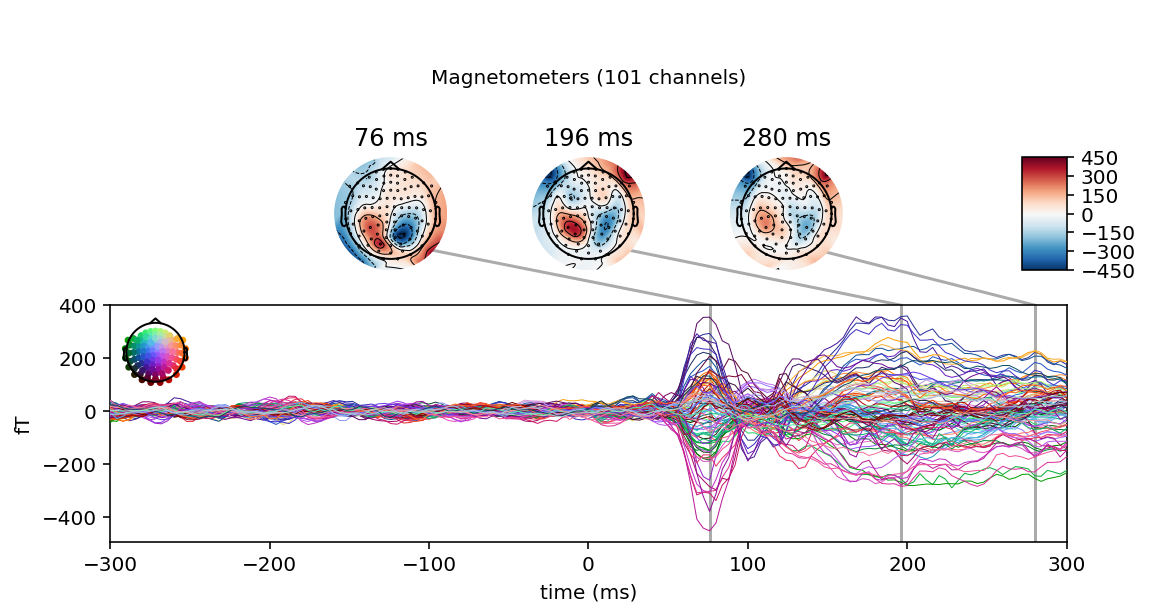

In [8]:
evoked = epochs.average()
evoked.plot_joint();

## Compute the data covariance matrix

For the computation of the beamformer, we need the data covariance matrix. Let's compute this on the brain activity between light onset and 300 ms after light onset.

We will plot the data covariance matrix and estimate it's _rank_ - to know whether we need regularization.

Estimating covariance using EMPIRICAL
Done.
Number of samples used : 8360
[done]


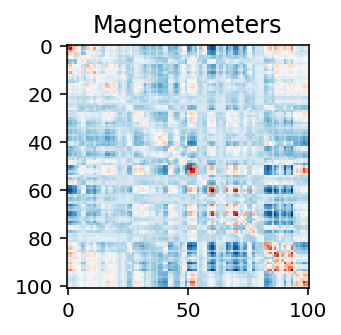

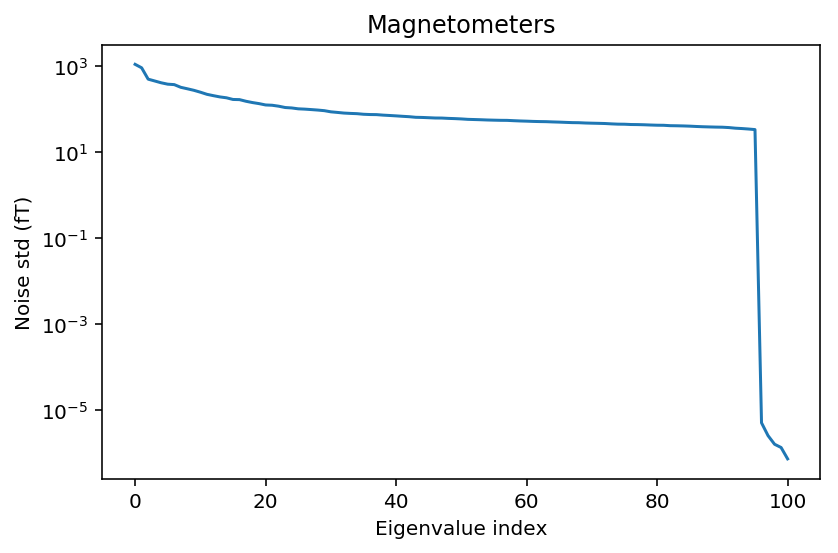

In [9]:
# compute covariance matrix:
data_cov = mne.compute_covariance(epochs, tmin=0, tmax=0.3)

# plot data covariance matrix:
fig_dc, fig_ds = data_cov.plot(evoked.info, show=False)

Estimating covariance using EMPIRICAL
Done.
Number of samples used : 8360
[done]


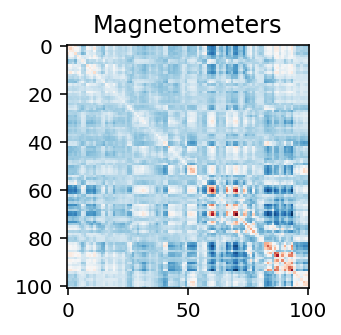

In [10]:
# calculate noise covariance matrix (for MNE)
noise_cov = mne.compute_covariance(epochs, tmin=-0.3, tmax=0)  # only needed for minimum norm

# optional: plot noise (baseline) covariance
fig_nc, _ = noise_cov.plot(evoked.info, show_svd=False, show=False)

### Effect of 'whitening' (zero mean, unit variance) the evoked response

The noise covariance matrix is used here

estimated rank (mag): 96
    Created an SSP operator (subspace dimension = 5)
estimated rank (mag): 96
Setting small MEG eigenvalues to zero.
Not doing PCA for MEG.
Total rank is 96


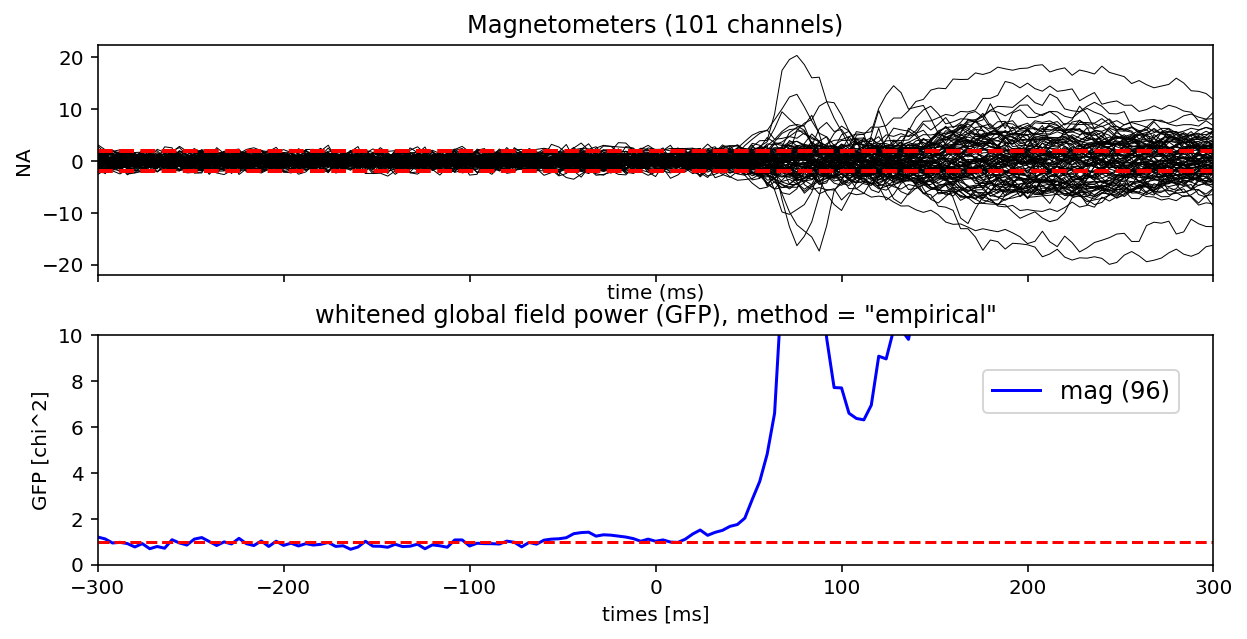

In [11]:
# Uncomment to see the 'whitened' evoked response
evoked.plot_white(noise_cov);

In [12]:
# estimate the rank, get the number of channels and trials:
from mne.utils import estimate_rank
rank_cov = estimate_rank(data_cov['data'], tol='auto')
ch_num = len(data_cov.ch_names)
tr_num = len(epochs.events)

# print an informative message about the covariance quality :-) 
print("%i trials, %i channels, covariance matrix has rank %i" % (tr_num, ch_num, rank_cov))

110 trials, 101 channels, covariance matrix has rank 96


## Compute the spatial filter

Now, let's compute the spatial filter = beamformer weights! 

We need some info from the data (e.g., included channels), the forward model and the data covariance for this.

We regularize with 5%, we do not include a noise covariance here, we pick the source orientation that maximizes our signal-to-noise ratio, and we use a special beamformer flavour, the Neural Activity Index (NAI) to correct for the depth bias.

_Note:_ While our forward model contains all channels, we only picked the magnetometers in our data -- hence the information about how many channels remain in our model!

In [13]:
lcmv_filt = make_lcmv(evoked.info, fwd, data_cov=data_cov, reg=0.05, 
                      # noise_cov=noise_cov_emp,  # uncomment to include noise-normalisation to LCMV
                      pick_ori='max-power', weight_norm='nai')

    101 out of 306 channels remain after picking


## Apply the spatial filter

After constructing our spatial filter, we can now apply it to our data!

We apply it to the evoked (averaged) data. Furthermore, we do not want to have power time series, therefore we specifiy ``max_ori_out='signed'``.)

In [14]:
stc = apply_lcmv(evoked, lcmv_filt, max_ori_out='signed')

## Visualize the source reconstructed signal

Finally, we can look at our results! 

First, we will look at our time series in the 30 voxels with maximum activity. Then, we will pick the maximum time point and plot the source activity of that time point on the subject's MRI!

**Maximum activity time series**

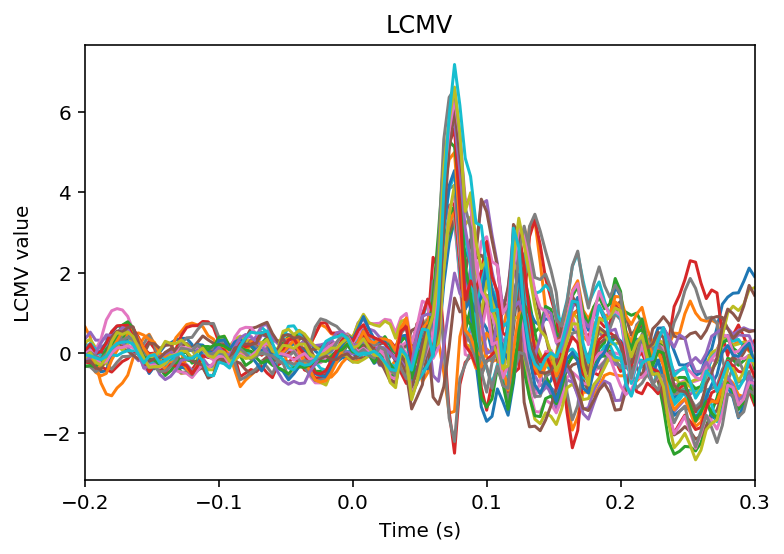

In [15]:
plt.figure()
# plot the time series of the 30 voxels with highest activity:
plt.plot(stc.times,
         stc.data[np.argsort(
            np.max(stc.data, axis=1))[-30:]].T)
# figure axes and title:
plt.xlabel('Time (s)')
plt.ylabel('LCMV value')
plt.xlim(-0.2, 0.30)
plt.title('LCMV')
# show figure
plt.show()

**Source map at maximum time point**

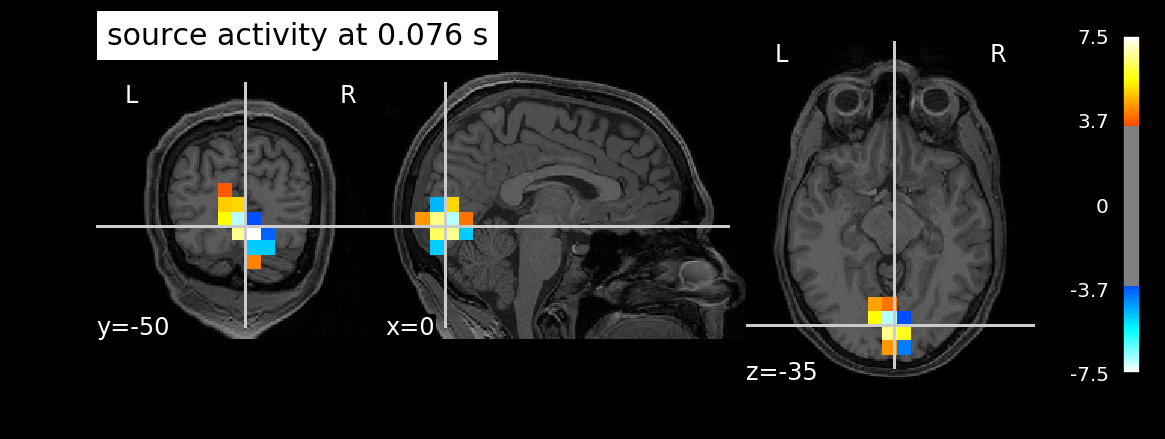

In [16]:
# get maximum time point
[maxvox, maxtp] = np.unravel_index(stc.data.argmax(), stc.data.shape)

# threshold for plotting: 50% of maximum value
thresh = np.max(stc.data) * 0.5  

# plot the activity on the MRI
# (this requires saving the image to disk first)
img = mne.save_stc_as_volume('foo.nii.gz', stc, fwd['src'], dest='mri', mri_resolution=False)
plot_stat_map(index_img(img, maxtp), t1_fname, threshold=thresh, 
              title='source activity at %.3f s' % stc.times[maxtp]);

## MNE

Let's calculate the 'dSPM'-flavour MNE on the same (volumetric) grid for comparison.

In [17]:
# loose=1 means no orientation constraints, i.e., source in each voxel allowed to be in any orientation
inv = mne.minimum_norm.make_inverse_operator(raw.info, fwd, noise_cov, loose=1)

Forward is not surface oriented, converting.
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 101 channels.
    Created an SSP operator (subspace dimension = 5)
estimated rank (mag): 96
Setting small MEG eigenvalues to zero.
Not doing PCA for MEG.
Total rank is 96
Creating the depth weighting matrix...
    101 magnetometer or axial gradiometer channels
    limit = 1519/1534 = 10.074317
    scale = 3.56228e-11 exp = 0.8
Computing inverse operator with 101 channels.
Creating the source covariance matrix
Whitening the forward solution.
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.
    largest singular value = 2.65506
    scaling factor to adjust the trace = 1.63088e+18


In [19]:
# Use default SNR of 3.0; lam = 1 / (SNR^2)
SNR = 3.0
stc_mne = mne.minimum_norm.apply_inverse(evoked, inv, lambda2=1/SNR**2)

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 110
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 5)
    Created the whitener using a full noise covariance matrix (5 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Picked 101 channels from the data
Computing inverse...
(eigenleads need to be weighted)...
combining the current components...
(dSPM)...
[done]


### Plot the estimated time courses

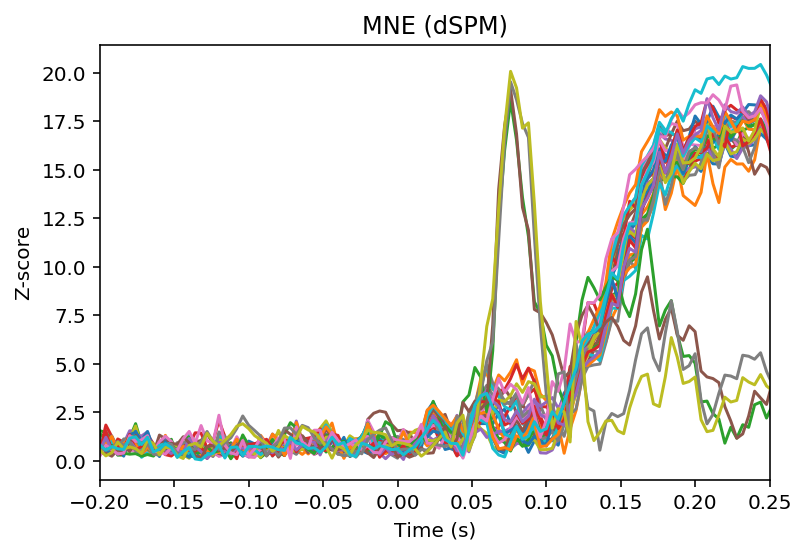

In [20]:
plt.figure()
# plot the time series of the 30 voxels with highest activity:
plt.plot(stc_mne.times,
         stc_mne.data[np.argsort(
            np.max(stc_mne.data, axis=1))[-30:]].T)
# figure axes and title:
plt.xlabel('Time (s)')
plt.ylabel('Z-score')
plt.xlim(-0.2, 0.25)
plt.title('MNE (dSPM)')
# show figure
plt.show()

In [21]:
# copy the initial peak for plotting code to work well
stc_mne_crop = stc_mne.copy()
stc_mne_crop.crop(tmax=0.150)

<VolSourceEstimate  |  1534 vertices, subject : sample, tmin : -300.0 (ms), tmax : 152.0 (ms), tstep : 4.0 (ms), data size : 1534 x 114>

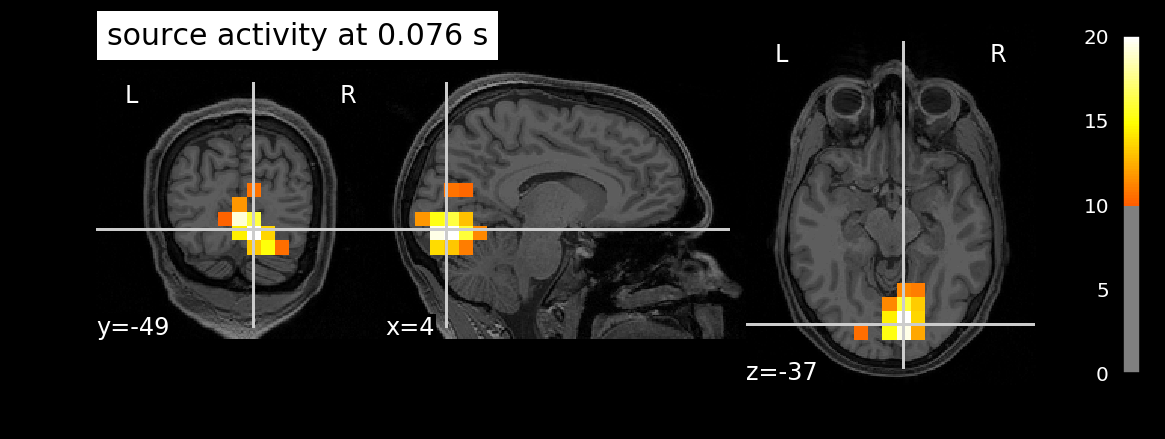

In [22]:
# get maximum time point
maxvox, maxtp = np.unravel_index(stc_mne_crop.data.argmax(), stc_mne_crop.data.shape)

# threshold for plotting: 50% of maximum value
thresh = np.max(stc_mne.data) * 0.50

# plot the activity on the MRI
# (this requires saving the image to disk first)
img = mne.save_stc_as_volume('foo.nii.gz', stc_mne, fwd['src'], dest='mri', mri_resolution=False)
plot_stat_map(index_img(img, maxtp), t1_fname, threshold=thresh, 
              title='source activity at %.3f s' % stc_mne.times[maxtp]);

__Now for the peak after 200 ms__

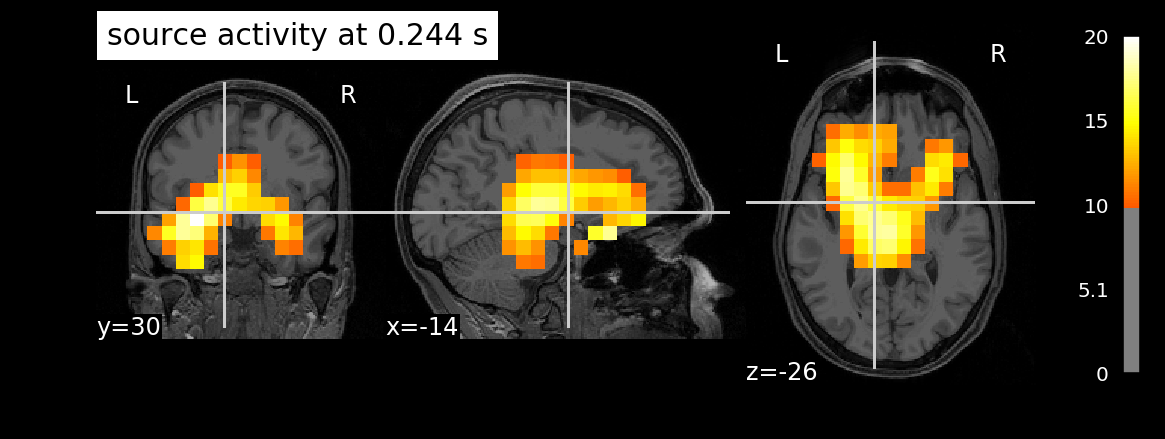

In [23]:
# get maximum time point
maxvox, maxtp = np.unravel_index(stc_mne.data.argmax(), stc_mne.data.shape)

# threshold for plotting: 50% of maximum value
thresh = np.max(stc_mne.data) * 0.50

# plot the activity on the MRI
# (this requires saving the image to disk first)
img = mne.save_stc_as_volume('foo.nii.gz', stc_mne, fwd['src'], dest='mri', mri_resolution=False)
plot_stat_map(index_img(img, maxtp), t1_fname, threshold=thresh, 
              title='source activity at %.3f s' % stc_mne.times[maxtp]);

MNE doesn't do a great job in the latter part of the ERP (possible eye-related artefacts that get 'localised' to widespread, deep parts of the brain).

### Compare to late LCMV peak

In [24]:
stc_lcmv_crop = stc.copy().crop(0.200, 0.280)

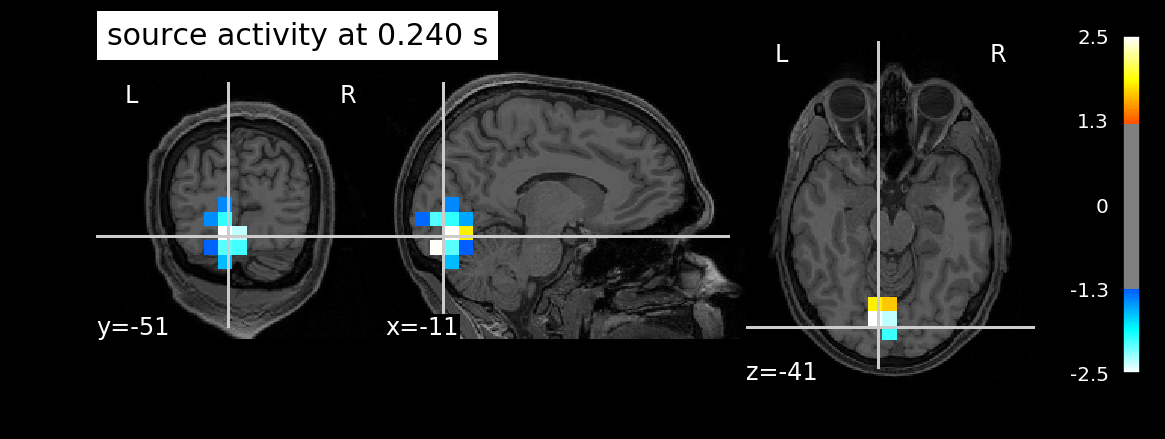

In [25]:
# get maximum time point
maxvox, maxtp = np.unravel_index(stc_lcmv_crop.data.argmax(), stc_lcmv_crop.data.shape)

# threshold for plotting: 50% of maximum value
thresh = np.max(stc_lcmv_crop.data) * 0.50

# plot the activity on the MRI
# (this requires saving the image to disk first)
img = mne.save_stc_as_volume('foo.nii.gz', stc_lcmv_crop, fwd['src'], dest='mri', mri_resolution=False)
plot_stat_map(index_img(img, maxtp), t1_fname, threshold=thresh, 
              title='source activity at %.3f s' % stc_lcmv_crop.times[maxtp]);

Looks like LCMV localises the later ERP peak component to the occipital lobe.